In [1]:
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
%matplotlib inline

leaspy_path = '/network/lustre/dtlake01/aramis/users/juliette.ortholand/leaspy/' #TO CHANGE

sys.path.append(leaspy_path)

from leaspy import Leaspy, IndividualParameters, AlgorithmSettings, Data

# Load 

In [2]:
df_normed = pd.read_csv("simulated_data-corrected.csv")
df_normed = df_normed.astype({'ID':'string'})
df_normed.set_index(['ID', 'TIME'], inplace=True)
print(len(df_normed))
df_normed.head()

1997


MDS1_total  MDS2_total  MDS3_off_total  SCOPA_total  \
ID     TIME                                                             
GS-001 71.354607    0.112301    0.122472        0.171078     0.160001   
       71.554604    0.140880    0.109504        0.118693     0.135852   
       72.054604    0.225499    0.270502        0.061310     0.211134   
       73.054604    0.132519    0.253548        0.258786     0.245323   
       73.554604    0.278923    0.321920        0.143350     0.223102   

                  MOCA_total  REM_total  PUTAMEN_R  PUTAMEN_L  CAUDATE_R  \
ID     TIME                                                                
GS-001 71.354607    0.275257   0.492485   0.780210   0.676774   0.622611   
       71.554604    0.380934   0.577203   0.751444   0.719796   0.618434   
       72.054604    0.351172   0.835828   0.823315   0.691504   0.717099   
       73.054604    0.377842   0.566496   0.813593   0.787914   0.770048   
       73.554604    0.292768   0.741811   0.888792   0.852720   0.797368   

                  CAUDATE_L   PUTAMEN  
ID     TIME                            
GS-001 71.354607   0.494641  0.728492  
       71.554604   0.530978  0.735620  
       72.054604   0.576978  0.757409  
       73.054604   0.709486  0.800754  
       73.554604   0.715465  0.870756

# Create cofactor

In [3]:
path_model = os.path.join(os.getcwd(),'..', '..',"TP2_leaspy_beginner/outputs/")
leaspy = Leaspy.load(path_model + 'model_parameters.json')

In [4]:
col = ["MDS1_total", "MDS2_total", "MDS3_off_total"]
data = Data.from_dataframe(df_normed.loc['GS-161':][col]) 

In [5]:
##SET PARAMETERS
settings_personalization = AlgorithmSettings('scipy_minimize', progress_bar=True)

##PREDICTIONS
ip = leaspy.personalize(data, settings_personalization)

|########################################|   40/40 subjects
The standard deviation of the noise at the end of the personalization is:
MDS1_total: 0.0468
MDS2_total: 0.0492
MDS3_off_total: 0.0578

Personalization scipy_minimize took: 8s


In [6]:
# —— Convert individual parameters to dataframe
df_ip = ip.to_dataframe()

<AxesSubplot:>

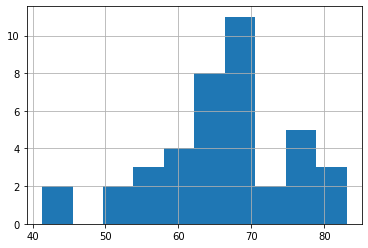

In [7]:
df_ip["tau"].hist()

<AxesSubplot:>

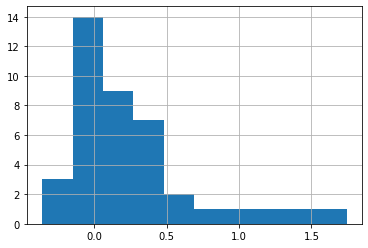

In [8]:
df_ip["xi"].hist()

In [9]:
df_cof = pd.DataFrame(0, columns = ['MUTATION'],index = df_ip.index)
for i in df_cof.index :
    if df_ip["tau"].loc[i]>70 and df_ip["xi"].loc[i]<0:
        df_cof.at[i,'MUTATION'] = 1
    elif df_ip["tau"].loc[i]>65 and df_ip["xi"].loc[i]<0.25:
        rd = random.randint(1, 3)
        if rd != 3 :
            df_cof.at[i,'MUTATION'] = 1
    elif df_ip["tau"].loc[i]>60 and df_ip["xi"].loc[i]<0.25:
        rd = random.randint(1, 3)
        if rd == 3 :
            df_cof.at[i,'MUTATION'] = 1

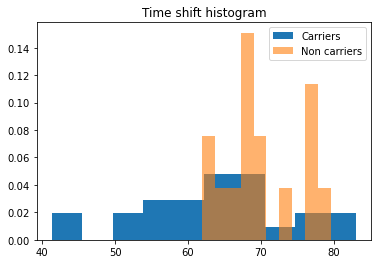

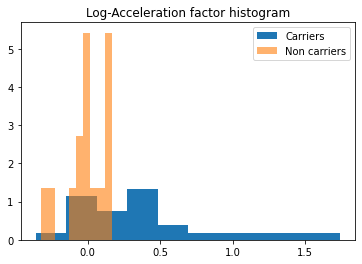

In [10]:
# —— Convert individual parameters to dataframe
df_ip = ip.to_dataframe()

# —— Merge with cofactors
df_ip = df_ip.join(df_cof)

# —— Separate the individual parameters with respect to the cofactor
carriers = df_ip[df_ip['MUTATION'] == 0.]
non_carriers = df_ip[df_ip['MUTATION'] == 1.]

# —— Plot the time shifts in carriers and non-carriers
plt.title('Time shift histogram')
plt.hist(carriers['tau'], density=True, label='Carriers')
plt.hist(non_carriers['tau'], density=True, alpha=0.6, label='Non carriers')
plt.legend()
plt.show()


# —— Plot the acceleration factor in carriers and non-carriers
plt.title('Log-Acceleration factor histogram')
plt.hist(carriers['xi'], density=True, label='Carriers')
plt.hist(non_carriers['xi'], density=True, alpha=0.6, label='Non carriers')
plt.legend()
plt.show()

In [11]:
# —— Student t-test (under the asumption of a gaussian distribution only)
print(stats.ttest_ind(carriers['tau'], non_carriers['tau']))
print(stats.ttest_ind(carriers['xi'], non_carriers['xi']))

# —— Mann-withney t-test
print(stats.mannwhitneyu(carriers['tau'], non_carriers['tau']))
print(stats.mannwhitneyu(carriers['xi'], non_carriers['xi']))

Ttest_indResult(statistic=-2.2232608961456144, pvalue=0.032220725282898224)
Ttest_indResult(statistic=3.1589836303335073, pvalue=0.0031005639237972477)
MannwhitneyuResult(statistic=110.0, pvalue=0.015731576990963104)
MannwhitneyuResult(statistic=78.0, pvalue=0.001162797898390688)


In [12]:
df_cof.to_csv("cof_leaspy1.csv")